# Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense,Flatten,Dropout,BatchNormalization,Activation,Input,SeparableConv2D,GlobalAveragePooling2D,concatenate
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import*
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Adamax
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model,Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
valid_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [3]:
train_dataset=train_datagen.flow_from_directory(directory='../input/fer2013/train',
                                               target_size=(48,48),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=64)

Found 22968 images belonging to 7 classes.


In [4]:
valid_dataset=valid_datagen.flow_from_directory(directory='../input/fer2013/test',
                                               target_size=(48,48),
                                               class_mode='categorical',
                                               batch_size=64)

Found 7178 images belonging to 7 classes.


In [5]:
test_dataset=test_datagen.flow_from_directory(directory='../input/fer2013/test',
                                               target_size=(48,48),
                                               class_mode='categorical',
                                               batch_size=64)

Found 7178 images belonging to 7 classes.


In [6]:
inputs=Input((48,48,3))

h=Conv2D(32,(1,1),padding='same',activation='relu')(inputs)
h=BatchNormalization()(h)
h=tf.nn.relu(h)
h=Conv2D(48,(3,3))(h)
h=BatchNormalization()(h)
#     h=MaxPooling2D((2,2),strides=(2,2))(h)
h=Activation('relu')(h)

b=Conv2D(128,(1,1),strides=(2,2))(h)
b=BatchNormalization()(b)

h=SeparableConv2D(128,(3,3),padding='same')(h)
h=BatchNormalization()(h)
h=tf.nn.relu(h)
h=Activation('relu')(h)
h=SeparableConv2D(128,(3,3),padding='same')(h)
h=BatchNormalization()(h)
h=MaxPooling2D((2,2),strides=(2,2))(h)

h=concatenate([h,b],name='first')

b=Conv2D(128,(2,2),strides=(2,2))(h)
b=BatchNormalization()(b)

h=SeparableConv2D(128,(3,3),padding='same')(h)
h=BatchNormalization()(h)
h=tf.nn.relu(h)
#     h=SeparableConv2D(128,(3,3),padding='same')(h)
#     h=BatchNormalization()(h)
h=MaxPooling2D((2,2),strides=(2,2))(h)

h=concatenate([h,b],name='second')

b=Conv2D(128,(1,1),padding='same')(h)
b=BatchNormalization()(b)
b=MaxPooling2D((2,2),strides=(2,2))(b)

h=SeparableConv2D(256,(3,3),padding='same')(h)
h=BatchNormalization()(h)
h=tf.nn.relu(h)
h=Activation('relu')(h)
h=SeparableConv2D(256,(3,3),padding='same')(h)
h=BatchNormalization()(h)
h=MaxPooling2D((2,2),strides=(2,2))(h)

h=concatenate([h,b],name='third')
b=h

h=tf.nn.relu(h)
h=SeparableConv2D(512,(3,3),padding='same')(h)
h=BatchNormalization()(h)
h=tf.nn.relu(h)
h=SeparableConv2D(512,(3,3),padding='same')(h)
h=BatchNormalization()(h)
h=tf.nn.relu(h)
h=SeparableConv2D(512,(3,3),padding='same')(h)
h=BatchNormalization()(h)

h=concatenate([h,b],name='fourth')

b=Conv2D(512,(1,1),padding='same')(h)
b=BatchNormalization()(b)
b=MaxPooling2D((2,2),strides=(2,2))(b)

h=SeparableConv2D(512,(3,3),padding='same')(h)
h=BatchNormalization()(h)
h=tf.nn.relu(h)
h=SeparableConv2D(512,(3,3),padding='same')(h)
h=BatchNormalization()(h)
h=MaxPooling2D((2,2),strides=(2,2))(h)

h=concatenate([h,b],name='fifth')

b=Conv2D(512,(1,1),padding='same')(h)
b=BatchNormalization()(b)
b=MaxPooling2D((2,2),strides=(2,2))(b)

h=SeparableConv2D(512,(3,3),padding='same')(h)
h=tf.nn.relu(h)
h=SeparableConv2D(512,(3,3),padding='same')(h)
h=BatchNormalization()(h)
h=MaxPooling2D((2,2),strides=(2,2))(h)

h=concatenate([h,b],name='sixth')
b=h

h=tf.nn.relu(h)

h=SeparableConv2D(512,(3,3),padding='same')(h)
h=BatchNormalization()(h)
h=tf.nn.relu(h)
h=SeparableConv2D(256,(3,3),padding='same')(h)
h=BatchNormalization()(h)
h=tf.nn.relu(h)
h=SeparableConv2D(256,(3,3),padding='same')(h)
h=BatchNormalization()(h)

h=concatenate([h,b],name='seventh')
b=h

b=Conv2D(256,(1,1),strides=(1,1))(h)
b=BatchNormalization()(b)

h=tf.nn.relu(h)
h=SeparableConv2D(512,(3,3),padding='same')(h)
h=BatchNormalization()(h)
h=tf.nn.relu(h)
h=SeparableConv2D(512,(3,3),padding='same')(h)
h=BatchNormalization()(h)

h=concatenate([h,b],name='eighth')

h=SeparableConv2D(256,(3,3),padding='same')(h)
h=BatchNormalization()(h)
h=tf.nn.relu(h)

h=GlobalAveragePooling2D()(h)

h=Dense(128,activation='relu')(h)
h=Dropout(0.4)(h)
h=Dense(64,activation='relu')(h)
h=Dropout(0.3)(h)
h=Dense(7,activation='softmax')(h)
    
outputs=h
    
model=Model(inputs=inputs,outputs=outputs)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 32)   128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 48, 48, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 tf.nn.relu (TFOpLambda)        (None, 48, 48, 32)   0           ['batch_normalization[0][0]']

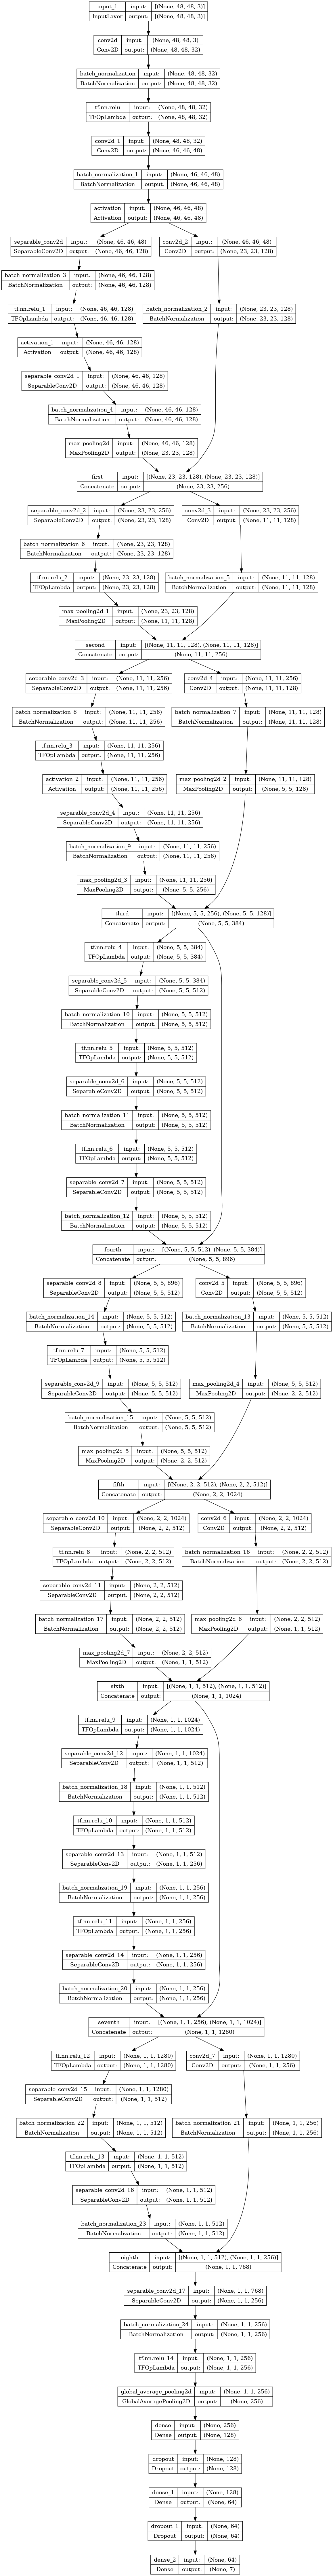

In [8]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model,to_file='model.png',show_shapes=True,show_layer_names=True)
Image(filename='model.png')

In [9]:
def f1_score(y_true,y_pred): #taken from old keras source code
    true_positives=K.sum(K.round(K.clip(y_true*y_pred,0,1)))
    possible_positives=K.sum(K.round(K.clip(y_true,0,1)))
    predicted_positives=K.sum(K.round(K.clip(y_pred,0,1)))
    precision=true_positives/(predicted_positives+K.epsilon())
    recall=true_positives/(possible_positives+K.epsilon())
    f1_val=2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [10]:
METRICS=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

In [11]:
lrd=ReduceLROnPlateau(monitor='val_loss',patience=20,verbose=1,factor=0.50,min_lr=0.00005)
mcp=ModelCheckpoint('model.h5')
es=EarlyStopping(verbose=1,patience=20)

In [12]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=METRICS)

In [13]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs=10,verbose=1,callbacks=[lrd,mcp,es])

Epoch 1/10
359/359 [==============================] - 175s 400ms/step - loss: 1.7734 - accuracy: 0.8590 - precision: 0.6011 - recall: 0.0395 - auc: 0.6785 - f1_score: 0.0715 - val_loss: 1.8552 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6461 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/10
359/359 [==============================] - 50s 140ms/step - loss: 1.5836 - accuracy: 0.8694 - precision: 0.7249 - recall: 0.1384 - auc: 0.7658 - f1_score: 0.2301 - val_loss: 1.6325 - val_accuracy: 0.8722 - val_precision: 0.6359 - val_recall: 0.2464 - val_auc: 0.7527 - val_f1_score: 0.3537 - lr: 0.0010
Epoch 3/10
359/359 [==============================] - 50s 140ms/step - loss: 1.4606 - accuracy: 0.8766 - precision: 0.7605 - recall: 0.1986 - auc: 0.8092 - f1_score: 0.3134 - val_loss: 1.5033 - val_accuracy: 0.8719 - val_precision: 0.5913 - val_recall: 0.3332 - val_auc: 0.8119 - val_f1_score: 0.4243 - lr: 0.0010
Epoch 4/10
359/359 [=========================

In [14]:
model_acc=model.evaluate(test_dataset,verbose=0)[1]
preds=model.predict(test_dataset)
y_preds=np.argmax(preds,axis=1)
y_test=np.array(test_dataset.labels)

113/113 [==============================] - 7s 53ms/step


**Confusion Matrix**

In [15]:
train_dir='../input/fer2013/train'
test_dir='../input/fer2013/test'

class_labels=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

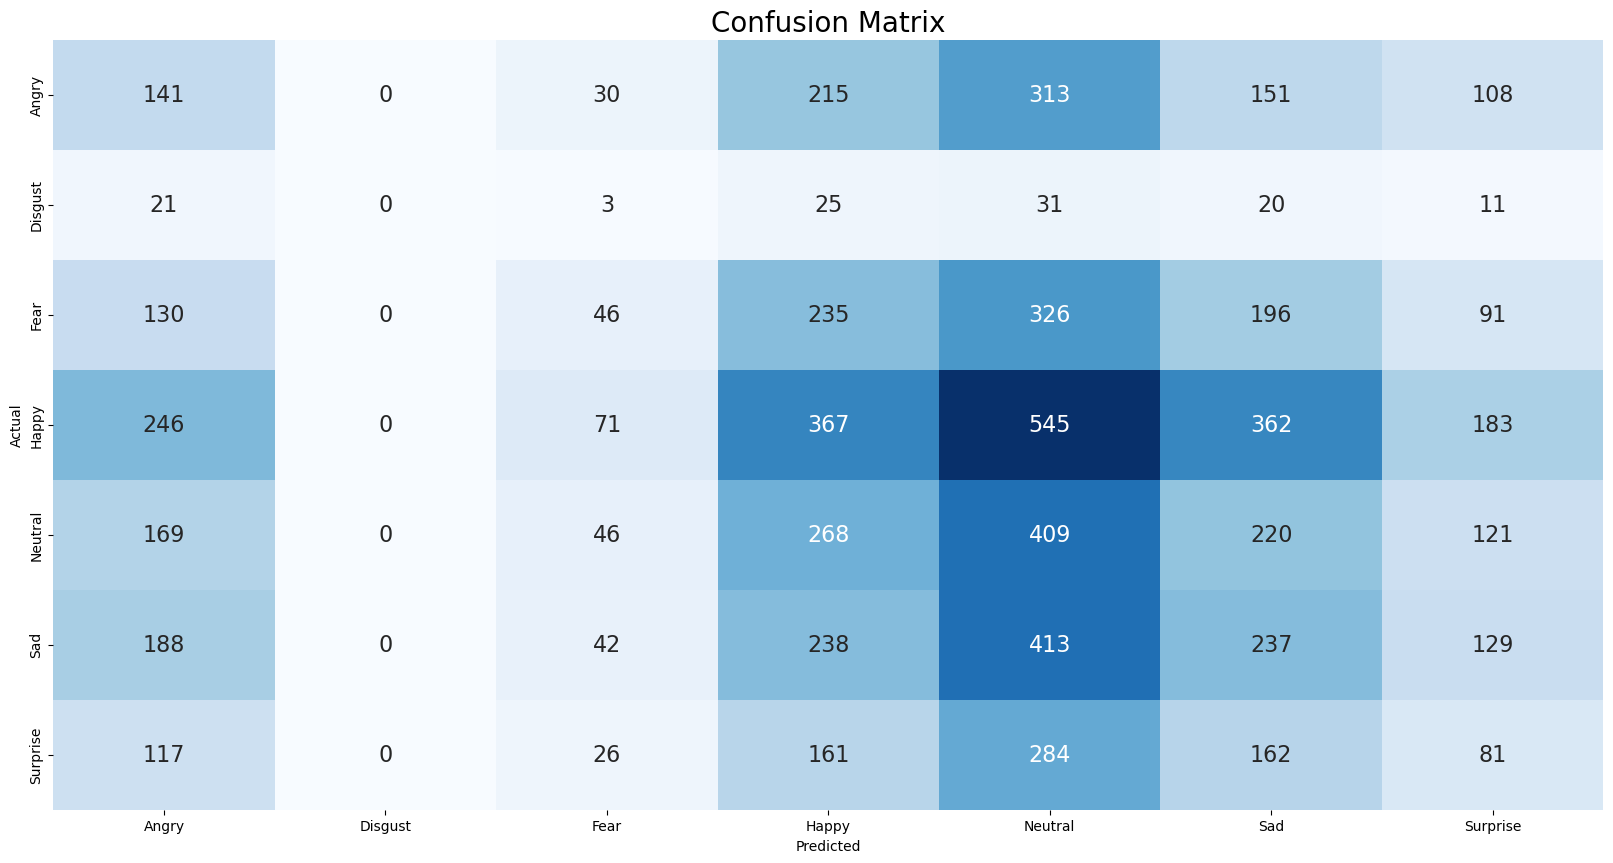

In [16]:
from sklearn.metrics import confusion_matrix,classification_report
cm_data=confusion_matrix(y_test,y_preds)
cm=pd.DataFrame(cm_data,columns=class_labels,index=class_labels)
cm.index.name="Actual"
cm.columns.name="Predicted"
plt.figure(figsize=(20,10))
plt.title('Confusion Matrix',fontsize=20)
sn.set(font_scale=1.2)
sn.set(font_scale=1.2)
ax=sn.heatmap(cm,cbar=False,cmap="Blues",annot=True,annot_kws={"size":16},fmt='g')

**Classification Report**

In [17]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.14      0.15      0.14       958
           1       0.00      0.00      0.00       111
           2       0.17      0.04      0.07      1024
           3       0.24      0.21      0.22      1774
           4       0.18      0.33      0.23      1233
           5       0.18      0.19      0.18      1247
           6       0.11      0.10      0.10       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.14      7178
weighted avg       0.18      0.18      0.17      7178



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Multiclass ROC curve**

ROC AUC score: 0.5563263407821019


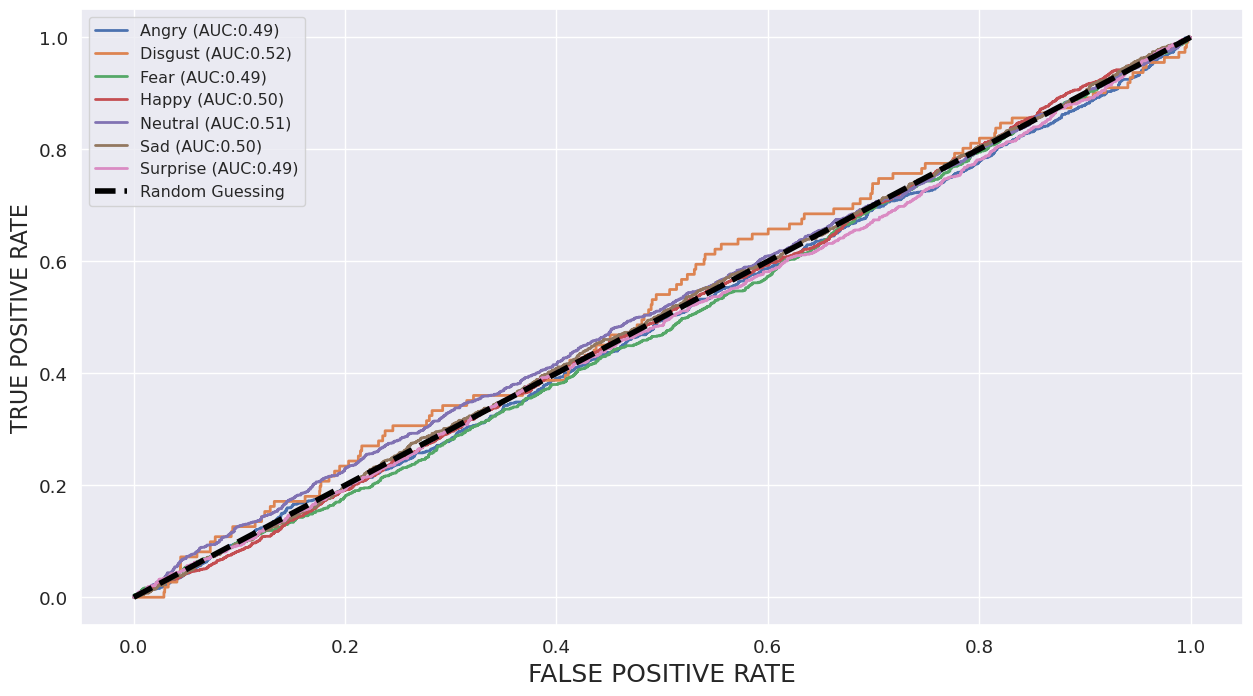

In [18]:
from sklearn.preprocessing import LabelBinarizer
fig,c_ax=plt.subplots(1,1,figsize=(15,8))
from sklearn.metrics import roc_curve,auc,roc_auc_score

def multiclass_roc_auc_score(y_test,y_preds,average='macro'):
    lb=LabelBinarizer()
    lb.fit(y_test)
    y_test=lb.transform(y_test)
    for(idx,c_label) in enumerate(class_labels):
        fpr,tpr,thresholds=roc_curve(y_test[:,idx].astype(int),y_preds[:,idx])
        c_ax.plot(fpr,tpr,lw=2,label='%s (AUC:%0.2f)'%(c_label,auc(fpr,tpr)))
    c_ax.plot(fpr,fpr,'black',linestyle='dashed',lw=4,label='Random Guessing')
    return roc_auc_score(y_test,y_preds,average=average)

print('ROC AUC score:',multiclass_roc_auc_score(y_test,preds,average='micro'))
plt.xlabel('FALSE POSITIVE RATE',fontsize=18)
plt.ylabel('TRUE POSITIVE RATE',fontsize=16)
plt.legend(fontsize=11.5)
plt.show()

In [19]:
from tensorflow.keras.utils import to_categorical
print("ROC-AUC Score=",roc_auc_score(to_categorical(y_test),preds))

ROC-AUC Score= 0.49985195594656495


In [20]:
acc=[]

In [21]:
acc.append(model_acc)

# Feature Extraction

# HOG

In [22]:
import os
from sklearn.model_selection import train_test_split

In [23]:
# from sklearn.model_selection import train_test_split

# #Get the list of image filenmaes in the train and test directories
# train_filenames=os.listdir(train_dir)
# test_filenames=os.listdir(test_dir)

# #separate the filenames into input features(images) and labels
# X_train=[os.path.join(train_dir,filename) for filename in train_filenames]
# y_train=[filename.split('.')[0] for filename in train_filenames]
# X_test=[os.path.join(test_dir,filename) for filename in test_filenames]
# y_test=[filename.split('.')[0] for filename in test_filenames]

# #split the dataset into training and testing subsets
# X_train,X_test,y_train,y_test=train_test_split(X_train,y_train,test_size=0.2,random_state=42)

#print the dataset sizes
print("Training dataset size:",len(train_dir))
print("Testing labels size:",len(test_dir))

Training dataset size: 22
Testing labels size: 21


In [24]:
!pip install Pillow

In [25]:
from skimage.transform import resize
from skimage.feature import hog
import random
import matplotlib.pyplot as plt
from skimage import io,color
from PIL import Image

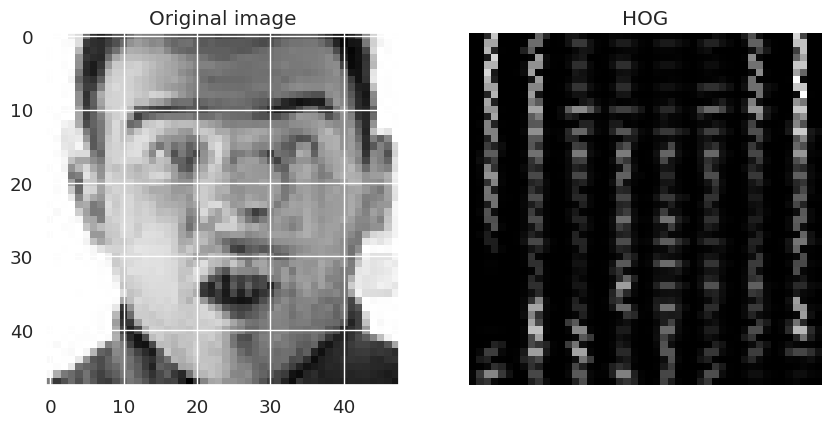

In [26]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
category_dir=random.choice(os.listdir(train_dir))
img_filename=random.choice(os.listdir(os.path.join(train_dir,category_dir)))
img_path=os.path.join(train_dir,category_dir,img_filename)
img=io.imread(img_path,as_gray=True)

if img.ndim==3:
    img=img[:,:,0] #If image has multiple channels use only one(grayscale)
#first image needs to be resized before passing it to HOG descriptor
resized_img=resize(img,(128,64))
plt.title('Original image')
plt.imshow(img,cmap='gray')
fd,hog_image=hog(
    resized_img,
    orientations=9,
    pixels_per_cell=(8,8),
    cells_per_block=(2,2),
    visualize=True,
    feature_vector=False
#     multichannel=False
)
plt.subplot(1,2,2)
plt.title("HOG")
plt.imshow(resize(hog_image,(48,48)),cmap='gray')
plt.axis('off')

plt.show()

# data=pd.read_csv('/kaggle/input/fer2013')

**Create feature vectors for training and testing**

In [27]:
# train_dir='/kaggle/input/fer2013/train/'
from skimage.io import imread

In [28]:
def create_HOG_features(data):
    Feature_data=np.zeros((len(data),48,48))
    
    for i in range(len(data)):
        img=data[i]
        resized_img=resize(img,(128,64))
        fd,hog_image=hog(
            resized_img,
            orientations=9,
            pixels_per_cell=(8,8),
            cells_per_block=(2,2),
            visualize=True,
            feature_vector=False,
#             multichannel=False
#             channel_axis=-1,
        )
        Feature_data[i]=resize(hog_image,(48,48))
    return Feature_data



# select whether to use the train or test directory
# use_train=True

#choose a random image from the train or test directory
# if use_train:
#     image_dir=train_dir
# else:
#     image_dir=test_dir
# image_dirs=[train_dir,test_dir]
    
# random_image_dir=random.choice(image_dirs)
# image_files=os.listdir(random_image_dir)
# random_image_file=random.choice(image_files)
# random_image_path=os.path.join(random_image_dir,random_image_file)

# #check if the randomly selected file is a directory, if so choose another file
# while os.path.isdir(random_image_path):
#     random_image_dir=random.choice(image_dirs)
#     image_files=os.listdir(random_image_dir)
#     random_image_file=random.choice(image_files)
#     random_image_path=os.path.join(random_image_dir,random_image_file)

# #read the random image
# image=imread(random_image_path,as_gray=True)

# #compute HOG features for the random image
# resized_img=resize(random_image,(128,64))
# hog_features,_=hog(
#     resized_img,
#     orientations=9,
#     pixels_per_cell=(8,8),
#     cells_per_block=(2,2),
#     visualize=False,
#     multichannel=False
# )



In [29]:
train_images=[]
for category_dir in os.listdir(train_dir):
    category_path=os.path.join(train_dir,category_dir)
    for img_filename in os.listdir(category_path):
        img_path=os.path.join(category_path,img_filename)
        img=io.imread(img_path,as_gray=True)
        train_images.append(img)
        
Feature_train=create_HOG_features(train_images)
print("Feature_train shape: ",Feature_train.shape)

Feature_train shape:  (28709, 48, 48)


In [30]:
#plot a random image and its HOG features
random_index=np.random.randint(len(train_images))
random_image=train_images[random_index]
random_hog_feature=Feature_train[random_index]

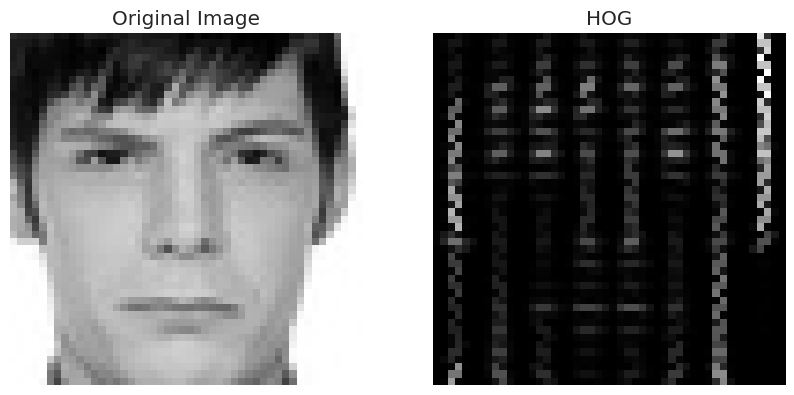

In [31]:
#plot the original image
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(random_image,cmap='gray')
plt.axis('off')

#plot the HOG image
plt.subplot(1,2,2)
plt.title('HOG')
plt.imshow(random_hog_feature,cmap='gray')
plt.axis('off')

plt.show()

In [32]:
#     Feature_train=create_HOG_features(train_images)
#     Feature_train.shape

In [33]:
# plt.imshow(random.choice(Feature_train),cmap='gray')
# plt.axis('off')

In [34]:
import os
test_images=[]
for category_dir in os.listdir(test_dir):
    category_path=os.path.join(test_dir,category_dir)
    for img_filename in os.listdir(category_path):
        img_path=os.path.join(category_path,img_filename)
        img=io.imread(img_path,as_gray=True)
        test_images.append(img)
        
#doing same for test data
Feature_test=create_HOG_features(test_images)
Feature_test.shape
print("Feature_test shape",Feature_test.shape)

Feature_test shape (7178, 48, 48)


In [35]:
# plt.imshow(random.choice(Feature_test),cmap='gray')

In [36]:
# #Adding again color channel as it got removed while converting img to hog img
# train_HOG=np.expand_dims(Feature_train,axis=3)
# test_HOG=np.expand_dims(Feature_test,axis=3)

# print('After adding color channel')
# print('train_HOG shape: ',train_HOG.shape)
# print('test_HOG shape: ',test_HOG.shape)

In [37]:
# print('train_HOG shape: ',train_HOG.shape)
# print('test_HOG shape: ',test_HOG.shape)

In [38]:
Feature_train=Feature_train/255.0
Feature_test=Feature_test/255.0

In [39]:
emotion_labels={
    'angry':0,
    'disgust':1,
    'fear':2,
    'happy':3,
    'neutral':4,
    'sad':5,
    'surprise':6
}

#Initialize the lists to store the labels
X_train=[]
X_test=[]
y_train=[]
y_test=[]

#Iterate over the train directory and assign labels
for category in os.listdir(train_dir):
    category_dir=os.path.join(train_dir,category)
    if os.path.isdir(category_dir):
        label=emotion_labels[category]
        for filename in os.listdir(category_dir):
            img_path=os.path.join(category_dir,filename)
            img=io.imread(img_path,as_gray=True)
            X_train.append(img)
            y_train.append(label)
        
#Iterate over the test directory and assign labels
for category in os.listdir(test_dir):
    category_dir=os.path.join(test_dir,category)
    if os.path.isdir(category_dir):
        label=emotion_labels[category]
        for filename in os.listdir(category_dir):
            img_path=os.path.join(category_dir,filename)
            img=io.imread(img_path,as_gray=True)
            X_test.append(img)
            y_test.append(label)
        
#convert the lists to NumPy arrays
import numpy as np
X_train=np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

In [40]:
#reshaping y_train and y_test
y_train=np.reshape(y_train,(len(y_train),1))
y_test=np.reshape(y_test,(len(y_test),1))

print("After reshaping")
print("y_train shape: ",y_train.shape)
print("y_test shape: ",y_test.shape)

After reshaping
y_train shape:  (28709, 1)
y_test shape:  (7178, 1)


**Adding color channel**

In [41]:
X_train=np.expand_dims(X_train,axis=3)
X_test=np.expand_dims(X_test,axis=3)

print("After adding color channel")
print("X_train shape: ",X_train.shape)
print("X_test shape: ",X_test.shape)

After adding color channel
X_train shape:  (28709, 48, 48, 1)
X_test shape:  (7178, 48, 48, 1)


**Normalizing pixel values**

In [42]:
X_train=X_train/255.0
X_test=X_test/255.0

**Converting single values to category array**

In [43]:
y_train[0]

array([6])

In [44]:
y_train=tf.keras.utils.to_categorical(y_train)
y_test=tf.keras.utils.to_categorical(y_test)

In [45]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [46]:
y_train.shape,y_test.shape

((28709, 7), (7178, 7))

In [47]:
# #Apply data augmentation to the test data
# X_test_augmented=valid_datagen.flow((X_test,shuffle=False).next())

# #Replace the augmented data back to the original shape
# X_test_augmented=X_test_augmented.reshape(X_test.shape)

In [48]:
HOG_model=model

In [49]:
HOG_model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [50]:
es1=EarlyStopping(
    monitor='val_accuracy',min_delta=0.0001,patience=10,verbose=2,mode='max',baseline=None,restore_best_weights=True
)
lr1=ReduceLROnPlateau(
    monitor='val_accuracy',factor=0.1,patience=5,verbose=2,mode='max',min_delta=0.007,cooldown=0,min_lr=0
)
# callbacks1=[es1,lr1]

# lrd=ReduceLROnPlateau(monitor='val_loss',patience=20,verbose=1,factor=0.50,min_lr=0.00005)
# mcp=ModelCheckpoint('model.h5')
# es=EarlyStopping(verbose=1,patience=20)

In [51]:
# # Reshape the input data to remove the extra dimension
# X_test = X_test.reshape(-1, 48, 48, 3)

In [52]:
Feature_train=np.expand_dims(Feature_train,axis=-1)
Feature_test=np.expand_dims(Feature_test,axis=-1)

In [53]:
Feature_train_rgb=np.repeat(Feature_train,3,axis=-1)
Feature_test_rgb=np.repeat(Feature_test,3,axis=-1)

In [54]:
# #Apply data augmentation to the test data
# Feature_test_augmented=valid_datagen.flow(Feature_test_rgb,shuffle=False).next()

# #Replace the augmented data back to the original shape
# Feature_test_augmented=Feature_test_augmented.reshape(X_test.shape)

Adding these lines at the begining of your code will clear any existing TensorFlow session,including any variables of functions that might have been defined previously. This can help resolve the "**creating variables on a non-first call**" error

In [55]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [56]:
HOG_history=HOG_model.fit(Feature_train_rgb,y_train,batch_size=8,epochs=50,validation_data=(Feature_test_rgb,y_test),callbacks=[lrd,es])

Epoch 1/50
3589/3589 [==============================] - 117s 26ms/step - loss: 1.5294 - accuracy: 0.4254 - val_loss: 10.6672 - val_accuracy: 0.1335 - lr: 0.0010
Epoch 2/50
3589/3589 [==============================] - 92s 26ms/step - loss: 1.4594 - accuracy: 0.4518 - val_loss: 1.9973 - val_accuracy: 0.1722 - lr: 0.0010
Epoch 3/50
3589/3589 [==============================] - 92s 26ms/step - loss: 1.3948 - accuracy: 0.4781 - val_loss: 3.6959 - val_accuracy: 0.1737 - lr: 0.0010
Epoch 4/50
3589/3589 [==============================] - 93s 26ms/step - loss: 1.3560 - accuracy: 0.4967 - val_loss: 3.6513 - val_accuracy: 0.1718 - lr: 0.0010
Epoch 5/50
3589/3589 [==============================] - 94s 26ms/step - loss: 1.3111 - accuracy: 0.5163 - val_loss: 3.0792 - val_accuracy: 0.1718 - lr: 0.0010
Epoch 6/50
3589/3589 [==============================] - 94s 26ms/step - loss: 1.2633 - accuracy: 0.5317 - val_loss: 13.2817 - val_accuracy: 0.1427 - lr: 0.0010
Epoch 7/50
3589/3589 [=====================

In [57]:
def plot_performance(history):
    plt.figure(figsize=(12,8))
    
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    
    plt.legend()
    plt.grid()
    plt.title('train and val loss evaluation')
    
    plt.subplot(2,1,2)
    plt.plot(history.history['accuracy'],label='train')
    plt.plot(history.history['val_accuracy'],label='val')
    
    plt.legend()
    plt.grid()
    plt.title('train and val accuracy')

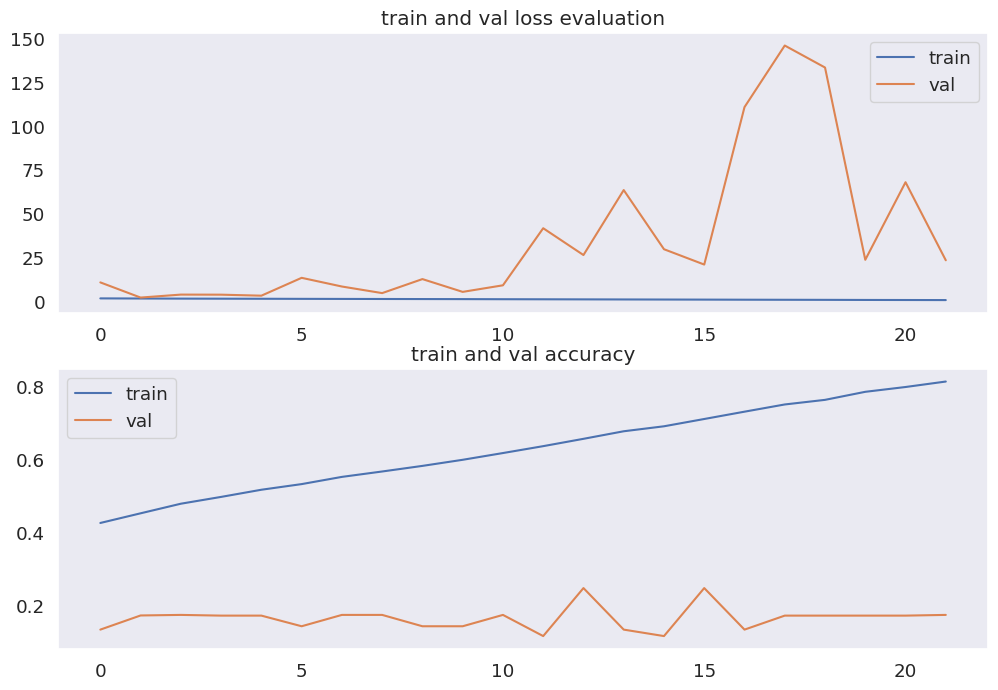

In [58]:
plot_performance(HOG_history)

In [59]:
# inputs=Input((48,48,3))

# h=Conv2D(32,(1,1),padding='same',activation='relu')(inputs)
# h=BatchNormalization()(h)
# h=tf.nn.relu(h)
# h=Conv2D(48,(3,3))(h)
# h=BatchNormalization()(h)
# #     h=MaxPooling2D((2,2),strides=(2,2))(h)
# h=Activation('relu')(h)

# b=Conv2D(128,(1,1),strides=(2,2))(h)
# b=BatchNormalization()(b)

# h=SeparableConv2D(128,(3,3),padding='same')(h)
# h=BatchNormalization()(h)
# h=tf.nn.relu(h)
# h=Activation('relu')(h)
# h=SeparableConv2D(128,(3,3),padding='same')(h)
# h=BatchNormalization()(h)
# h=MaxPooling2D((2,2),strides=(2,2))(h)

# h=concatenate([h,b],name='first')

# b=Conv2D(128,(2,2),strides=(2,2))(h)
# b=BatchNormalization()(b)

# h=SeparableConv2D(128,(3,3),padding='same')(h)
# h=BatchNormalization()(h)
# h=tf.nn.relu(h)
# #     h=SeparableConv2D(128,(3,3),padding='same')(h)
# h=BatchNormalization()(h)
# h=MaxPooling2D((2,2),strides=(2,2))(h)

# h=concatenate([h,b],name='second')

# b=Conv2D(128,(1,1),padding='same')(h)
# b=BatchNormalization()(b)
# b=MaxPooling2D((2,2),strides=(2,2))(b)

# h=SeparableConv2D(256,(3,3),padding='same')(h)
# h=BatchNormalization()(h)
# h=tf.nn.relu(h)
# h=Activation('relu')(h)
# h=SeparableConv2D(256,(3,3),padding='same')(h)
# h=BatchNormalization()(h)
# h=MaxPooling2D((2,2),strides=(2,2))(h)

# h=concatenate([h,b],name='third')
# b=h

# h=tf.nn.relu(h)
# h=SeparableConv2D(512,(3,3),padding='same')(h)
# h=BatchNormalization()(h)
# h=tf.nn.relu(h)
# h=SeparableConv2D(512,(3,3),padding='same')(h)
# h=BatchNormalization()(h)
# h=tf.nn.relu(h)
# h=SeparableConv2D(512,(3,3),padding='same')(h)
# h=BatchNormalization()(h)

# h=concatenate([h,b],name='fourth')

# b=Conv2D(512,(1,1),padding='same')(h)
# b=BatchNormalization()(b)
# b=MaxPooling2D((2,2),strides=(2,2))(b)

# h=SeparableConv2D(512,(3,3),padding='same')(h)
# h=BatchNormalization()(h)
# h=tf.nn.relu(h)
# h=SeparableConv2D(512,(3,3),padding='same')(h)
# h=BatchNormalization()(h)
# h=MaxPooling2D((2,2),strides=(2,2))(h)

# h=concatenate([h,b],name='fifth')

# b=Conv2D(512,(1,1),padding='same')(h)
# b=BatchNormalization()(b)
# b=MaxPooling2D((2,2),strides=(2,2))(b)

# h=SeparableConv2D(512,(3,3),padding='same')(h)
# h=tf.nn.relu(h)
# h=SeparableConv2D(512,(3,3),padding='same')(h)
# h=BatchNormalization()(h)
# h=MaxPooling2D((2,2),strides=(2,2))(h)

# h=concatenate([h,b],name='sixth')
# b=h

# h=tf.nn.relu(h)

# h=SeparableConv2D(512,(3,3),padding='same')(h)
# h=BatchNormalization()(h)
# h=tf.nn.relu(h)
# h=SeparableConv2D(256,(3,3),padding='same')(h)
# h=BatchNormalization()(h)
# h=tf.nn.relu(h)
# h=SeparableConv2D(256,(3,3),padding='same')(h)
# h=BatchNormalization()(h)

# h=concatenate([h,b],name='seventh')
# b=h

# b=Conv2D(256,(1,1),strides=(1,1))(h)
# b=BatchNormalization()(b)

# h=tf.nn.relu(h)
# h=SeparableConv2D(512,(3,3),padding='same')(h)
# h=BatchNormalization()(h)
# h=tf.nn.relu(h)
# h=SeparableConv2D(512,(3,3),padding='same')(h)
# h=BatchNormalization()(h)

# h=concatenate([h,b],name='eighth')

# h=SeparableConv2D(256,(3,3),padding='same')(h)
# h=BatchNormalization()(h)
# h=tf.nn.relu(h)

# h=GlobalAveragePooling2D()(h)

# h=Dense(128,activation='relu')(h)
# h=Dropout(0.4)(h)
# h=Dense(64,activation='relu')(h)
# h=Dropout(0.3)(h)
# h=Dense(7,activation='softmax')(h)
    
# outputs=h
    
# other_model=Model(inputs=inputs,outputs=outputs)

In [60]:
# predictions_1=HOG_model.predict(Feature_test_rgb)
# predictions_2=other_model.predict(Feature_test_rgb)

# #Average the predictions
# ensemble_predictions=np.mean([predictions_1,predictions_2],axis=0)

In [61]:
# print(ensemble_predictions)

In [62]:
HOG_acc=HOG_model.evaluate(Feature_test_rgb,y_test,verbose=0)[1]
# acc.append(HOG_acc)
print("HOG Accuracy : ",HOG_model.evaluate(Feature_test_rgb,y_test,verbose=0)[1])

HOG Accuracy :  0.17372527718544006


In [63]:
# 1-0.14265812933444977

In [64]:
HOG_model.save('HOG_model.h5')

# LBP

In [65]:
def Binarypattern(im): #creating function to get local binary pattern
    img=np.zeros_like(im)
    n=3 #taking kernel of size 3x3
    for i in range(0,im.shape[0]-n): # for image height
        for j in range(0,im.shape[1]-n): #for image width
            x=im[i:i+n,j:j+n] #reading the image in 3x3 format
            center=x[1,1] #taking the center value for 3x3 kernel
            img1=(x>=center)*1.0 #checking if neighboring values of center value is greater or less than the center value
            img1_vector=img1.T.flatten() #getting the image pixel values
            img1_vector=np.delete(img1_vector,4)
            digit=np.where(img1_vector)[0]
            if len(digit)>=1: #converting the neighboring pixels according to center pixel value
                num=np.sum(2**digit) #if n>center assign 1 and if n<center assign 0
            else: #if 1 then multiply by 2^digit and if 0 then making value 0 and aggregating all the values of kernel to get new center value
                num=0
            img[i+1,j+1]=num
    return(img)

**LBP looks like**

(-0.5, 47.5, 47.5, -0.5)

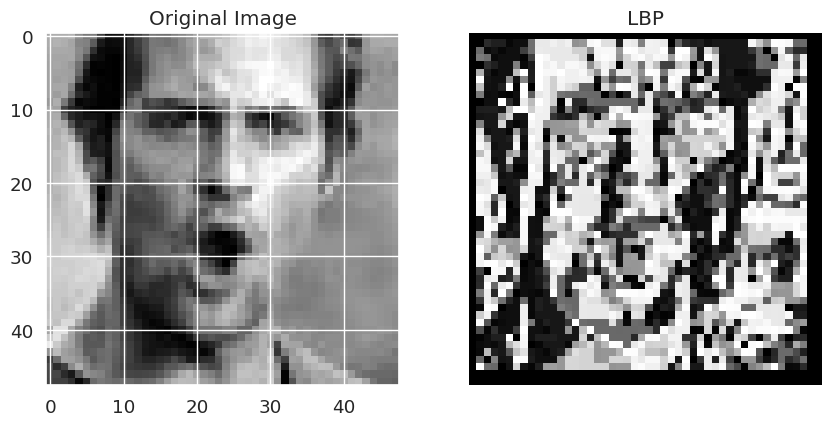

In [66]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
img=random.choice(X_train)
plt.title('Original Image')
plt.imshow(img,cmap='gray')

plt.subplot(1,2,2)
plt.title('LBP')
imgLBP=Binarypattern(img) #calling the LBP function using gray image
plt.imshow(imgLBP,cmap='gray')
plt.axis('off')

**Create feature vectors for training and testing**

In [67]:
X_train.shape

(28709, 48, 48, 1)

In [68]:
def create_LBP_features(data):
    Feature_data=np.zeros(data.shape)
    
    for i in range(len(data)):
        img=data[i]
        imgLBP=Binarypattern(img)
        Feature_data[i]=imgLBP
        
    return Feature_data

In [69]:
Feature_X_train=create_LBP_features(X_train)

In [70]:
Feature_X_train.shape

(28709, 48, 48, 1)

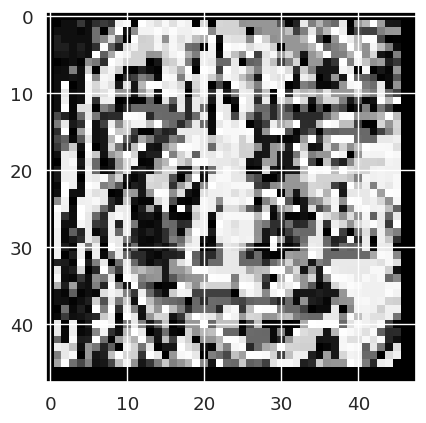

In [71]:
img=random.choice(Feature_X_train)
plt.imshow(img,cmap='gray')

In [72]:
Feature_X_test=create_LBP_features(X_test)
Feature_X_test.shape

(7178, 48, 48, 1)

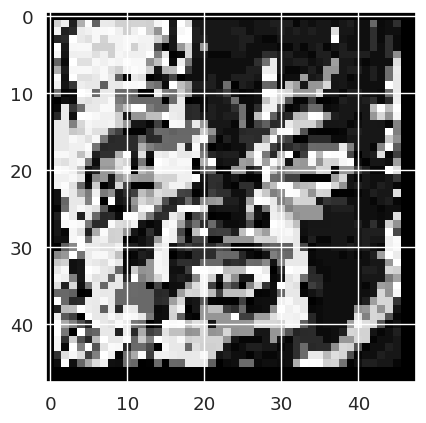

In [73]:
img=random.choice(Feature_X_test)
plt.imshow(img,cmap='gray')

**Training and Testing LBP-CNN model**

In [74]:
Feature_X_train_rgb=np.repeat(Feature_X_train,3,axis=-1)
Feature_X_test_rgb=np.repeat(Feature_X_test,3,axis=-1)

In [75]:
LBP_model=model
LBP_model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [76]:
LBP_history=LBP_model.fit(Feature_X_train_rgb,y_train,batch_size=8,epochs=50,validation_data=(Feature_X_test_rgb,y_test),callbacks=[lrd,es])

Epoch 1/50
3589/3589 [==============================] - 118s 27ms/step - loss: 1.4510 - accuracy: 0.4615 - val_loss: 1.2964 - val_accuracy: 0.5081 - lr: 0.0010
Epoch 2/50
3589/3589 [==============================] - 96s 27ms/step - loss: 1.2537 - accuracy: 0.5398 - val_loss: 1.2730 - val_accuracy: 0.5096 - lr: 0.0010
Epoch 3/50
3589/3589 [==============================] - 99s 28ms/step - loss: 1.1517 - accuracy: 0.5842 - val_loss: 1.2134 - val_accuracy: 0.5414 - lr: 0.0010
Epoch 4/50
3589/3589 [==============================] - 94s 26ms/step - loss: 1.0555 - accuracy: 0.6249 - val_loss: 1.3185 - val_accuracy: 0.5188 - lr: 0.0010
Epoch 5/50
3589/3589 [==============================] - 96s 27ms/step - loss: 0.9649 - accuracy: 0.6600 - val_loss: 1.2704 - val_accuracy: 0.5464 - lr: 0.0010
Epoch 6/50
3589/3589 [==============================] - 96s 27ms/step - loss: 0.8715 - accuracy: 0.6947 - val_loss: 1.2711 - val_accuracy: 0.5439 - lr: 0.0010
Epoch 7/50
3589/3589 [=======================

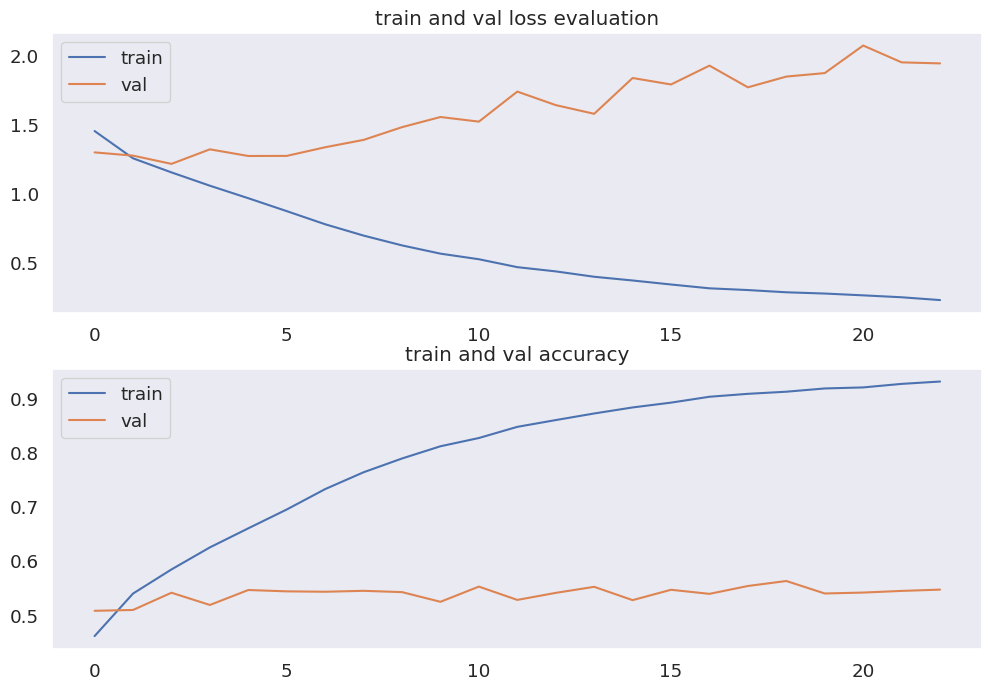

In [77]:
plot_performance(LBP_history)

In [78]:
LBP_acc=LBP_model.evaluate(Feature_X_test_rgb,y_test,verbose=0)[1]
acc.append(LBP_acc)
print("LBP accuracy: ",LBP_model.evaluate(Feature_X_test_rgb,y_test,verbose=0)[1])

LBP accuracy:  0.5470883250236511


In [79]:
LBP_model.save('LBP_model.h5')